In [2]:
import matplotlib.pyplot as plt
import re
!pip install requests
!pip install BeautifulSoup4
!pip install tqdm
!pip install natasha
!pip install numpy

In [3]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt

In [4]:
headers = {
    "User-Agent": "Mozilla/5.0 \
           (Macintosh; Intel Mac OS X 10_10_1) \
           AppleWebKit/537.36 (KHTML, like Gecko) \
           Chrome/39.0.2171.95 Safari/537.36"
}

In [5]:
baseUrl = 'https://career.habr.com/vacancies?type=all'

In [6]:
request = requests.get(baseUrl, headers=headers)
cont = request.content

In [7]:
soup = BeautifulSoup(request.content, 'html.parser')

In [8]:
soup.title

<title>Работа и свежие вакансии для IT специалистов от прямых работодателей — Хабр Карьера</title>

# Task 1

### Fetch at least 100 non-blank carreers


#### Creating links

In [9]:
divis = ['backend','frontend','apps','software','testing','administration','design',
             'management','marketing','analytics','sale','content','support','hr','telecom',
             'other','office','security']
massOfStrings = []

In [10]:
parseLink = 'https://career.habr.com/vacancies?divisions[]={}&type=all'
parseLinkNum = 'https://career.habr.com/vacancies?divisions[]={}&type=all&page={}'

In [11]:
for i in divis:
    massOfStrings.append(parseLink.format(i))

Parsing salaries through all pages and all divisions

In [12]:
salaries = {}

for i in tqdm(divis,'parsing some salaries data...'):
    page = 1
    salaries[i] = []
    while True: # Идея выхода из цикла через reqests.ok для парсинга всех страниц взята у Андрея Савчука

        r = requests.get(parseLinkNum.format(i,str(page)),headers=headers)

        if not r.ok: # Реализация этой идеи
            break

        soup = BeautifulSoup(r.content, 'html.parser')
        vacancyCard = soup.find_all('div', 'vacancy-card')

        if vacancyCard == []:
            break

        for card in vacancyCard:
            salary = card.find('div','vacancy-card__salary').find('div','basic-salary').text
            salaries[i].append(salary)

        # print(vacancyCard)

        # for i in vacancyCard:
        #     print(i.find('div','vacancy-card__salary').find('div','basic-salary').text)
        #

        page += 1

parsing some salaries data...: 100%|██████████| 18/18 [04:38<00:00, 15.49s/it]


In [13]:
safeSal = salaries
safeSal

{'backend': ['',
  '',
  'от 2 500 до 3 500 $',
  '',
  '',
  '',
  '',
  'от 80 000 до 140 000 ₽',
  '',
  '',
  'от 170 000 до 250 000 ₽',
  '',
  '',
  '',
  'от 100 000 ₽',
  'от 200 000 до 250 000 ₽',
  '',
  'от 70 000 до 140 000 ₽',
  'от 3 000 до 5 000 $',
  '',
  '',
  '',
  'от 260 000 ₽',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'от 180 000 до 300 000 ₽',
  'от 80 000 ₽',
  'от 2 500 до 4 500 $',
  'от 100 000 до 120 000 ₽',
  'от 2 400 до 3 000 $',
  '',
  '',
  'от 300 000 ₽',
  'от 150 000 ₽',
  'До 425 000 ₽',
  'от 2 500 до 3 500 €',
  'от 270 000 до 450 000 ₽',
  'от 250 000 до 300 000 ₽',
  '',
  'от 3 000 $',
  '',
  'от 160 000 до 200 000 ₽',
  '',
  '',
  'До 2 500 $',
  '',
  '',
  '',
  'от 250 000 до 300 000 ₽',
  'от 8 000 $',
  'от 6 000 $',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'До 350 000 ₽',
  '',
  'от 250 000 ₽',
  'от 2 000 до 3 500 $',
  'от 120 000 до 150 000 ₽',
  'от 250 000 ₽',
  'от 120 000 до 150 000 ₽',
  'До 3 500 $',
  'от 45 000

## Clean-Up Process

Getting RUB-USD/RUB-EURO/RUB-TENGE/RUB-YAH

In [14]:
cbrLink = 'https://www.cbr-xml-daily.ru/daily_json.js'
data = requests.get(cbrLink)
df = data.json()['Valute']
usdMultiplier = df['USD']['Value']
euMultiplier = df['EUR']['Value']
uahMultiplier = df['UAH']['Value']
kztMultiplier = df['KZT']['Value']

In [15]:
print(usdMultiplier,euMultiplier,uahMultiplier,kztMultiplier)

69.8104 81.0289 26.4809 16.3586


### Deleting all NaN elements

In [16]:
for divisionSal in safeSal:
    safeSal[divisionSal] = list(filter(lambda a: a != '', safeSal[divisionSal]))

### Dealing with spaces and adding Valute

In [17]:
for divis in safeSal:
    counter = 0
    for line in safeSal[divis]:
        result = re.findall(r'\d+',line)
        result.append(line[len(line)-1])
        if len(result) >= 5:
            minimalSal = int(result[0]+result[1])
            maximalSal = int(result[2]+result[3])
            result = [minimalSal, maximalSal, result[len(result)-1]]
            safeSal[divis][counter] = result
            counter += 1
        else:
            sal = int(result[0]+result[1])
            result = [sal,line[len(line)-1]]
            safeSal[divis][counter] = result
            counter += 1

### Converting Valutes into Rubles

In [18]:
for divis in safeSal:
    for line in safeSal[divis]:
        if line[len(line)-1] == '$':
            if len(line) == 3:
                line[0] *= usdMultiplier
                line[1] *= usdMultiplier
                line[len(line)-1] = '₽'
            else:
                line[0] *= usdMultiplier
                line[len(line)-1] = '₽'
        elif line[len(line)-1] == '€':
            if len(line) == 3:
                line[0] *= euMultiplier
                line[1] *= euMultiplier
                line[len(line)-1] = '₽'
            else:
                line[0] *= euMultiplier
                line[len(line)-1] = '₽'
        elif line[len(line)-1] == '₴':
            if len(line) == 3:
                line[0] *= uahMultiplier
                line[1] *= uahMultiplier
                line[len(line)-1] = '₽'
            else:
                line[0] *= uahMultiplier
                line[len(line)-1] = '₽'
        elif line[len(line)-1] == '₸':
            if len(line) == 3:
                line[0] *= kztMultiplier
                line[1] *= kztMultiplier
                line[len(line)-1] = '₽'
            else:
                line[0] *= kztMultiplier
                line[len(line)-1] = '₽'
        else:
            if len(line) == 3:
                line[0] = int(line[0])
                line[1] = int(line[1])
                line[len(line)-1] = '₽'
            else:
                line[0] = int(line[0])
                line[len(line)-1] = '₽'

### Plotting data and giving answer on Task 1

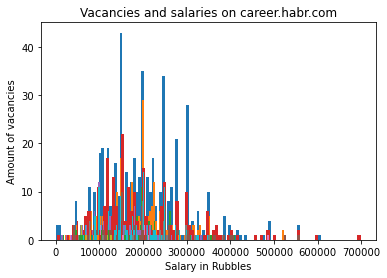

In [19]:
summ = 0
ansMass = []
for div in safeSal:
    averaged = []
    maximum = 0

    for line in safeSal[div]:
        if len(line) == 3:
            if line[1] > maximum:
                maximum = line[1]
            average = (line[0]+line[1])/2
            if average > 1200000:
                average /= 100
            averaged.append(average)
        else:
            if line[0] > maximum:
                maximum = line[0]
            if line[0] > 1200000:
                line[0] /= 100
            averaged.append(line[0])

    ansMass.append([div,maximum])
    plt.hist(averaged, bins = 100)
    plt.xlabel('Salary in Rubbles')
    plt.ylabel('Amount of vacancies')
    plt.title('Vacancies and salaries on career.habr.com')


In [20]:
summ = 0
for i in averaged:
    summ += i
summ/len(averaged)

203476.62857142856

#### We can see, that the biggest amount of vacancies offer salaries between 110k and 250k with less offers on +300k and < 70 offers on +400k. The division with the heighest salary is

In [21]:
divName = ansMass[0][0]
maxim = ansMass[0][1]
for i in range(1,len(ansMass)):
    if ansMass[i][1] > maximum:
        maximum = ansMass[i][1]
        divName = ansMass[i][0]
print(divName, 'with salary =', maximum,'rub')

apps with salary = 6282936.0 rub
